In [1]:
# import display libs
from IPython.display import Image
%matplotlib inline
from IPython.display import Latex

In [2]:
# import libs
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt


# setup figure params
figureparams = {'axes.labelsize': 24,
           'axes.titlesize': 20,
           'axes.linewidth': 1.3,
           'font.size': 20,
           'legend.fontsize': 18,
           'figure.figsize': (10,7),
           'font.family': 'serif',
           'font.serif': 'Computer Modern Roman',
           'xtick.labelsize': 18,
           'xtick.major.size': 5.5,
           'xtick.major.width': 1.3,
           'ytick.labelsize': 18,
           'ytick.major.size': 5.5,
           'ytick.major.width': 1.3,
           'text.usetex': True,
           'figure.autolayout': True}
plt.rcParams.update(figureparams)
matplotlib.rcParams['text.usetex']=False
matplotlib.rcParams['text.latex.unicode']=True
matplotlib.get_configdir()

C:\Users\EdwardJansenADC\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.


'C:\\Users\\EdwardJansenADC\\.matplotlib'

# $R^2$, coefficient of determination
### Contents
    1. Definition
    2. Confidence
        a. Analytical confidence interval
        b. Bootstrapped confidence interval

## 1. Definition

$R^2$ is often used to assess the match beween model outcomes $\hat{y}_i$ and the corresponding observations $y_i$. It is intuitively understood as the proportion of variability in the observations that the model is able to explain.

$R^2$ is often used as a measure of goodness of fit in a linear regression. The reason for this is that with a 'least squares' cost function, the fitted model will maximize its $R^2$. As such, it is a natural choice as metric. 

The metric will lie between $0$ and $1$ when the model is a linear least squares regression. In the case the model performs worse than a point estiamte given by the mean of the population, the metric can be negative.

Formally, the metric is defined as
\begin{equation}
R^2 = 1 - \frac{\sum_i (y_i - \hat{y}_i )^2}{\sum_i (y_i - \bar{y} )^2},
\end{equation}
where $\bar{y}$ is the mean of the observed outcomes. 

###### Adjusted $R^2$
When performing a regression, $R^2$ can always be increased by adding more explanatory variables, as this will always increase the amount of information fed into model. This, however, will lead to poor generalization and is therefore unwanted. As such, one will want to use the adjusted $R^2$ metric, which corrects for the number of explanatory variables used. It is defined as
\begin{equation}
R^2_\text{adj} = 1 - \left[ \left( \frac{n-1}{n-k-1} \right) (1- R^2)\right],
\end{equation}
where $k$ is the number of independent variables.

In [10]:
# generate binary data
N = 100
S = np.round(np.random.rand(N), 1)
Y_hat = np.round(S)

rand_idx = np.round( np.random.rand(np.int(N/5))*N).astype(int)
Y = Y_hat.copy()
for i in rand_idx:
    if Y[i] == 1.:
        Y[i] = 0.
    else:
        Y[i] = 1.

In [11]:
# generate continuous data
x = np.linspace(0,N-1, N)
y = x + np.random.randn(N)*10
y_hat = x.copy()

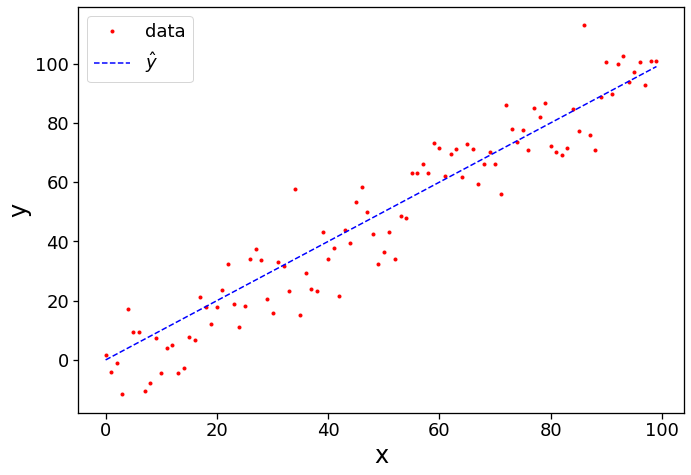

In [12]:
# visualize everything
plt.plot(x, y, 'r.', label='data')
plt.plot(x, y_hat, 'b--', label='$\hat{y}$')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [13]:
# Compute simple R2
res = y - y_hat
y_norm = y - np.mean(y)
R2 = 1 - np.sum(res**2) / np.sum( y_norm**2 )


# adjusted R2
N = 100 # number obs
p = 1 # number of expl. vars

corr_factor = (N-1) / (N - p - 1)
R2_adj = 1 - corr_factor*(1-R2)

# print results
print("R2: "+str(R2))
print("adjusted R2: " + str(R2_adj))

R2: 0.9087175291383837
adjusted R2: 0.9077860753540814


## 2. Confidence
#### 2a. Analytical confidence interval

Under a set of very specific conditions, it is possible to derive an analytical confidence interval for $R^2$. These are:
- linearity of the model;
- normal distribution of the target variable and the residuals;
- pairwise independence of the target variable and residuals;
- independence of the residuals with respect to the explanatory variables.

Given these assumptions and under the $H_0$ that the residuals and the data have the same variance (i.e. $R^2 = 0$), one can show that the following statistic follows a Fisher distribution:
\begin{equation}
\frac{ \frac{ \sum_i(y_i - \bar{y})^2 - \sum_i (y_i - \hat{y}_i)^2}{ k }  }{\frac{\sum_i (y_i - \hat{y}_i )^2}{N-k-1}}
\end{equation}

As such, $H_0$ is rejected when the test statistic is greater than $F(1-\alpha, k , N-k-1)$.

Alternatively, one can determine the confidence interval as
\begin{equation}
R^{2} \pm 2 \cdot SE_{R^{2}} \hspace{5pt} \text{   with   }  \hspace{5pt}  SE_{R^{2}} = \sqrt{\frac{4R^{2}(1-R^{2})^{2}(n-k-1)^{2}}{(n^2 - 1)(n+3)}}.
\end{equation}
This result is valid only when $N-k-1 > 60$. For more info, see https://stats.stackexchange.com/questions/175026/formula-for-95-confidence-interval-for-r2 and the refs therein.

In [15]:
#   the quantity below follows a Fisher distribution
test_statistic = ( (np.sum(y_norm**2) - np.sum(res**2)) / p )  /   ( np.sum(res**2) / N-p-1)

# import Fisher distribution
from scipy.stats import f 

# compute critical value
alpha = 0.05
cv = f.ppf(1.0 - alpha, p, N-p-1)

print("test statistic ?> critical value: " + str(test_statistic >= cv)) 

# confidence interval
SE_R2 = np.sqrt( (4*R2*(1-R2)**2*(N-p-1)**2) / ((N**2-1)*(N+3))  )

CI_low = R2 - 2*SE_R2
CI_up = R2 + 2*SE_R2
print("SE; real R2 lies within: (" + str(CI_low) + ", " + str(CI_up) + ")")
print("Observed R2: " + str(R2))

test statistic ?> critical value: True
SE; real R2 lies within: (0.8751057879738058, 0.9423292703029615)
Observed R2: 0.9087175291383837


#### 2b. Bootstrapped confidence interval

A third option is to find the confidence interval through bootstrapping. We bootstrap through resampling the data and then computing the prediction $\hat{y}$. This is somewhat weird in this case, because we construct the data instead of actually fitting a model. We can do it nonetheless. To do so, consider $(x_i, y_i)$ to be a pair and then resample those with replacement.

For more info: https://www.textbook.ds100.org/ch/18/hyp_regression.html

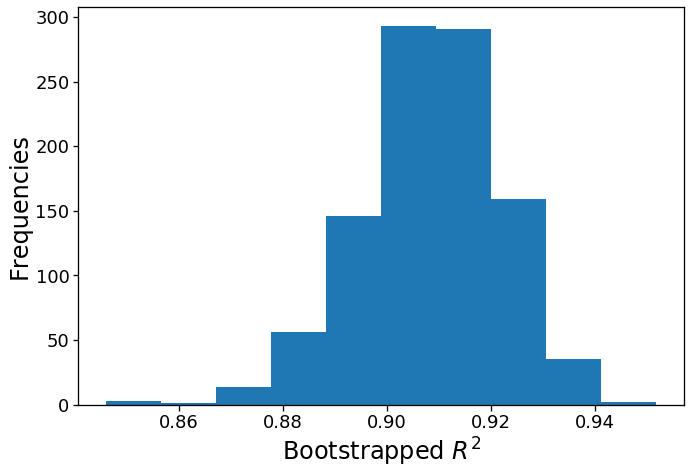

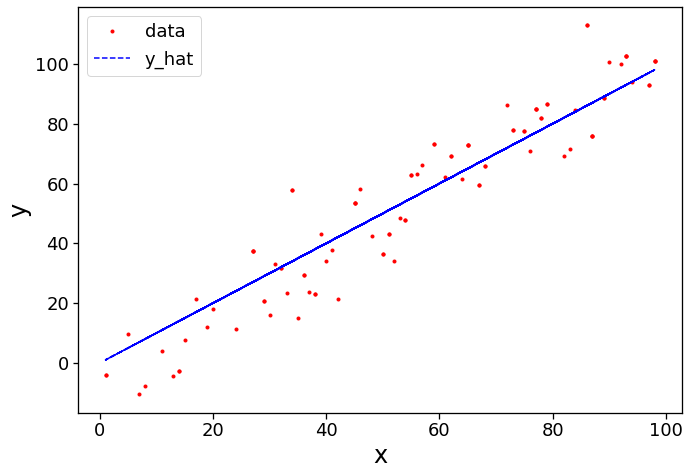

Bootstrap; real R2 lies within: (0.88, 0.933)
SE; real R2 lies within: (0.875, 0.942)
Observed R2: 0.909


In [18]:
# bootstrap 
n_iter = 1000
R2_boots = []
for i in range(n_iter):
    idx = (np.random.rand(N)*N).astype(int)
    # bootstrap pairs
    x = np.linspace(0,N-1, N)
    x_boot = x[idx]
    y_boot = y[idx]
    # compute model y_hat
    y_hat = x_boot.copy()            # here normally goes how y_hat is computed from y
    # compute res
    res = y_boot - y_hat
    y_norm = y_boot - np.mean(y)
    R2_tmp = 1 - np.sum(res**2) / np.sum( y_norm**2 )
    R2_boots.append(R2_tmp)

# check distr bootstrapped R2
plt.hist(R2_boots)
plt.xlabel('Bootstrapped $R^2$')
plt.ylabel('Frequencies')
plt.show()

# check
plt.plot(x_boot, y_boot, 'r.', label='data')
plt.plot(x_boot, y_hat, 'b--', label='y_hat')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


def confidence_interval(sim, alpha):
    """
    Return 2-sided symmetric confidence interval specified
    by p.
    """
    n = len(sim)
    u_pval = 1 - alpha/2
    l_pval = alpha / 2
    l_idx = int(np.floor(n*l_pval))
    u_idx = int(np.floor(n*u_pval))
    return(sim[l_idx], sim[u_idx])

bounds = confidence_interval(np.sort(R2_boots), 0.05)
print("Bootstrap; real R2 lies within: (" + str(np.round(bounds[0],3)) + ", " + str(np.round(bounds[1],3)) + ")")
print("SE; real R2 lies within: (" + str(np.round(CI_low, 3)) + ", " + str(np.round(CI_up, 3)) + ")")
print("Observed R2: " + str(np.round(R2, 3)))